### Imports

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as scp

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold
import torch.nn.functional as F

from ucimlrepo import fetch_ucirepo

In [3]:
wine = fetch_ucirepo(id = 109)

In [4]:
wine_df = pd.concat([wine['data']['features'], wine['data']['targets']], axis = 1)

weights and biases are joined within one matrix

In [5]:
# # testing concat by columns
# test_weights = torch.ones((4, 5))
# display(test_weights)
# test_biases = torch.zeros((4, 1))
# display(test_biases)
# test_concat = torch.concat([test_weights, test_biases], dim = 1)
# display(test_concat)

In [6]:
# # testing concat by rows
# test_weights = torch.ones((3, 4))
# display(test_weights)
# test_biases = torch.zeros((2, 4))
# display(test_biases)
# test_concat = torch.concat([test_weights, test_biases], dim = 0)
# display(test_concat)

In [7]:
# # testing stack by rows
# test_weights = torch.ones((3, 4))
# display(test_weights)
# test_biases = torch.zeros((3, 4))
# display(test_biases)
# test_concat = torch.stack([test_weights, test_biases], dim = 0)
# test_concat2 = torch.stack([test_weights, test_biases], dim = 2)
# display(test_concat)
# display(test_concat2)
# display(test_concat2.shape)

In [8]:
# # testing matrix multiplication in pytorch

# # assume 50 samples, 12 features and we include a bias term
# X = torch.randn((50, 12))
# bias_ones = torch.ones((X.shape[0], 1))

# W = torch.randn((X.shape[1] + 1, 1))
# X_aug = torch.concat([bias_ones, X], dim = 1)

# display(X_aug.shape)
# display(X_aug[:, 0])

# y = X_aug @ W
# display(y.shape)


In [9]:
# # testing out torch.softmax
# yhat = torch.randn(10, 3)
# display(yhat)
# sftmx = torch.softmax(yhat, dim = 1)
# display(sftmx)

# # testing out conditionals for tensors
# yprobs = torch.sigmoid(torch.randn(5, 1))
# display(yprobs)
# preds = (yprobs > 0.5).int()
# display(preds)

# test = torch.randn(10, 3)
# display(test)
# t = torch.argmax(test, dim = 1).reshape((-1, 1))
# display(t)

### Loss Functions and Grads

In [ ]:
# def l2_loss(y_hat, y):
#     loss = torch.sum((y_hat - y)**2)
#     return loss

def l1_loss(y_hat, y):
    loss = torch.sum(torch.abs(y_hat - y))
    # print(loss)
    return loss

def l2_loss(y_hat, y):
    loss = torch.sum((y_hat - y)**2)
    return loss

def mean_square_loss(y_hat, y):
    loss = torch.mean((y_hat - y)**2)
    return loss

def ce_loss(y_hat, y):
    # initial definition
    loss = torch.mean(torch.sum(-y * torch.log(y_hat), dim = 1))

    # numerically stable CE
    # logits = torch.log(y_hat) - torch.log(y_hat - 1)
    # loss = torch.sum(-y * torch.log1p(logits))
    return loss


def get_mse_grad(X, y, y_hat):
    dW = (2/X.shape[0]) * (X.T @ (y_hat - y))
    db = (2/X.shape[0]) * torch.sum(y_hat - y)
    return dW, db

def get_bce_grad(X, y, y_hat):
    dW = X.T @ (y_hat - y)
    db = torch.mean(y_hat - y, dim = 0)
    return dW, db


def get_log_reg_grad(X, y, y_hat):
    dW = X.T @ (y_hat - y) / X.shape[0]
    db = torch.sum(y_hat - y) / X.shape[0]
    # db = torch.mean(y_hat - y, dim = 0)
    return dW, db

def get_mce_reg_grad(X, y, y_hat):
    pass

### Models

In [ ]:
class LinearRegression:
    def __init__(self, num_features, num_classes, loss_fn, get_grad):
        self.num_features = num_features
        self.num_classes = num_classes
        self.loss_fn = loss_fn
        self.get_grad = get_grad
        self.losses = []

        self.init_weights()

    def init_weights(self):
        self.W = torch.normal(0, 0.01, (self.num_features, self.num_classes), dtype = torch.float32)
        self.b = torch.zeros(self.num_classes, dtype = torch.float32)       # could try an array of biases to see if it helps

    def fit(self, X, y, epochs = 1000, lr = 0.01, loss_threshold = 1e-3):
        # enforce right dimensions
        assert X.shape[1] == self.num_features and y.shape[1] == self.num_classes
        self.losses = []
        
        # computes the gradient descent version of linear regression
        for t in range(epochs):
            
            y_hat = self.forward(X)
            loss = self.loss_fn(y_hat, y)
            self.losses.append(loss)

            if loss < loss_threshold:
                break

            # compute gradient
            # dW = (2/X.shape[0]) * (X.T @ (y_hat - y))
            # db = (2/X.shape[0]) * torch.sum(y_hat - y)
            dW, db = self.get_grad(X, y, y_hat)

            # dW = 2 * torch.matmul(X.T, y_hat - y) / X.shape[0]
            # db = 2 * (y_hat - y).mean(dim=0)

            # update features
            self.W = self.W - (lr * dW)
            self.b = self.b - (lr * db)
    def display_weights(self):
        display('displaying weights..')
        display(self.W)
        display(self.b)

    def fit_OLS(self, X, y):
        assert X.shape[1] == self.num_features and y.shape[1] == self.num_classes

        # compute OLS solution
        W_OLS = torch.inverse(X.T @ X) @ X.T @ y
        b_OLS = torch.mean(y) - torch.mean(X @ self.W)
        self.W = W_OLS
        self.b = b_OLS

    def __call__(self, X):
        return self.forward(X)

    def forward(self, X):
        # assert X is of the shape (num_inputs, num_features)
        assert X.shape[1] == self.num_features
        return (X @ self.W) + self.b
    
    def predict_proba(self, X_val):
        if self.num_classes == 1:
            return torch.sigmoid(self.forward(X_val))
        else:
            # display(self.forward(X_val))
            return torch.softmax(self.forward(X_val), dim = 1)
    def predict(self, X_val):
        # also split into 2 cases for binary- and multi- classification
        if self.num_classes == 1:
            # binary classification
            preds = self.predict_proba(X_val)
            return (preds > 0.5).int()
        else:
            # multiclassification
            preds = self.predict_proba(X_val)
            
            temp = torch.argmax(preds, dim = 1)
            return F.one_hot(temp, self.num_classes)
            
            # return torch.argmax(preds, dim = 1).reshape((-1, 1))    # could get rid of the reshape
            

    # TODO: DOES NOT WORK
    def verify_grad(self, X, y, threshold):
        epsilon = 1e-5

        wd = self.W[0]
        w_minus_d = self.W[1:]
        wpos = wd + epsilon
        wneg = wd - epsilon

        approx_dw = (self.loss_fn(wpos, w_minus_d) - self.loss_fn(wneg, w_minus_d))/(2*epsilon)

        y_hat = self.forward(X)
        analytical_dw, _ = self.get_grad(X, y, y_hat)

        result = ((analytical_dw - approx_dw)**2)/((analytical_dw + approx_dw)**2)
        # display(result)
        return result < threshold

In [ ]:
class SoftmaxRegression():
    def __init__(self, num_features, num_classes, 
                 loss_fn = ce_loss, 
                 get_grad = get_mce_reg_grad):
        self.num_features = num_features
        self.num_classes = num_classes
        self.loss_fn = loss_fn
        self.get_grad = get_grad
        self.losses = []

        self.init_weights()

    def init_weights(self):
        self.W = torch.normal(0, 0.01, (self.num_features, self.num_classes), dtype = torch.float32)
        self.b = torch.zeros(self.num_classes, dtype = torch.float32)       # could try an array of biases to see if it helps

    def fit(self, X, y, epochs = 1000, lr = 0.01, loss_threshold = 1e-3):
        # enforce right dimensions
        assert X.shape[1] == self.num_features and y.shape[1] == self.num_classes
        self.losses = []
        
        # computes the gradient descent version of linear regression
        for t in range(epochs):
            
            y_hat = self.forward(X)
            loss = self.loss_fn(y_hat, y)
            self.losses.append(loss)

            if loss < loss_threshold:
                break


            # compute gradient
            # dW = (2/X.shape[0]) * (X.T @ (y_hat - y))
            # db = (2/X.shape[0]) * torch.sum(y_hat - y)
            dW, db = self.get_grad(X, y, y_hat)

            # dW = 2 * torch.matmul(X.T, y_hat - y) / X.shape[0]
            # db = 2 * (y_hat - y).mean(dim=0)

            # update features
            self.W = self.W - (lr * dW)
            self.b = self.b - (lr * db)
    def display_weights(self):
        display('displaying weights..')
        display(self.W)
        display(self.b)


    def __call__(self, X):
        return self.forward(X)

    def forward(self, X):
        # assert X is of the shape (num_inputs, num_features)
        assert X.shape[1] == self.num_features
        return torch.softmax((X @ self.W) + self.b, dim = 1)
    
    def predict_proba(self, X_val):
        if self.num_classes == 1:
            return self.forward(X_val)
        else:
            # display(self.forward(X_val))
            return self.forward(X_val)
    def predict(self, X_val):
        # also split into 2 cases for binary- and multi- classification
        if self.num_classes == 1:
            # binary classification
            preds = self.forward(X_val)
            temp = torch.argmax(preds, dim = 1)
            return temp
        else:
            # multiclassification
            preds = self.forward(X_val)
            
            temp = torch.argmax(preds, dim = 1)
            return F.one_hot(temp, self.num_classes)

    # TODO: DOES NOT WORK
    def verify_grad(self, X, y, threshold):
        epsilon = 1e-5

        wd = self.W[0]
        w_minus_d = self.W[1:]
        wpos = wd + epsilon
        wneg = wd - epsilon

        approx_dw = (self.loss_fn(wpos, w_minus_d) - self.loss_fn(wneg, w_minus_d))/(2*epsilon)

        y_hat = self.forward(X)
        analytical_dw, _ = self.get_grad(X, y, y_hat)

        result = ((analytical_dw - approx_dw)**2)/((analytical_dw + approx_dw)**2)
        # display(result)
        return result < threshold

In [12]:
# # testing out onehot
# t3 = torch.rand(size = (10, 3))

# preds = torch.argmax(t3, dim = 1)
# display(t3)
# display(preds)
# onehot = F.one_hot(preds)
# display(onehot)

In [13]:
# class LogisticRegression:

#     def __init__(self, num_features, loss_fn, get_grad):
#         self.num_features = num_features
#         self.loss_fn = loss_fn
#         self.get_grad = get_grad
#         self.losses = []

#         self.init_weights
#     def init_weights(self):
#         self.W = torch.normal(0, 1, size = (self.num_features, 1))
#         self.b = 0.

#     def fit(self, X, y, epochs = 1000, lr = 0.01, loss_threshold = 1e-3):
#         assert X.shape[1] == self.num_features

#         self.losses = []
#         for epoch in epochs:
#             y_hat = self.forward(X)

#             # compute loss
#             loss = self.loss_fn(y_hat, y)
#             self.losses.append(loss)
#             if loss < loss_threshold:
#                 break

#             # compute gradient
#             # dW = 2 * (X.T @ (y_hat - y)) / X.shape[0]
#             # db = 2 * torch.sum(y_hat - y) / X.shape[0]
#             dW, db = self.get_grad(X, y, y_hat)

#             # update weights
#             self.W = self.W - (lr * dW)
#             self.b = self.b - (lr * db)

#     def fit_OLS(self, X, y):
        
#         W_OLS = torch.inverse(X.T @ X) @ X.T @ y
#         b_OLS = torch.mean(y) - torch.mean(X @ W_OLS)

#         self.W = W_OLS
#         self.b = b_OLS

#     def forward(self, X):
#         return torch.sigmoid(X @ self.W + self.b)
    
#     def __call__(self, X):
#         return self.forward(X)
    
#     def predict_proba(self, X):
#         return self.forward(X)

#     def predict(self, X):
#         return (self.forward(X) > 0.5).int()
    
#     def verify_grad(self, X, y, threshold):
#         epsilon = 1e-5

#         wd = self.W[0]
#         w_minus_d = self.W[1:]
#         wpos = wd + epsilon
#         wneg = wd - epsilon

#         approx_dw = (self.loss_fn(wpos, w_minus_d) - self.loss_fn(wneg, w_minus_d))/(2*epsilon)

#         y_hat = self.forward(X)
#         analytical_dw = self.get_grad(X, y, y_hat)

#         result = ((analytical_dw - approx_dw)**2)/((analytical_dw + approx_dw)**2)

#         return result < threshold

### Transform data

magnesium, ash and color intensity look like useless features

In [14]:
# normalize features
wine_std = wine_df.copy()
normalizer = StandardScaler()
onehot = OneHotEncoder()

wine_X = wine_df.drop(columns = ['class'])

wine_y = wine_df[['class']].copy()
wine_y = pd.get_dummies(wine_y['class'], dtype = float)

wine_X_std = normalizer.fit_transform(wine_X)

pcc_matrix = wine_X_std.T @ wine_y / wine_y.shape[0]
display(pcc_matrix)

,1,2,3
0,0.304677,-0.355686,0.051009
1,-0.096900,-0.144538,0.241438
2,0.107925,-0.177483,0.069558
3,-0.244617,0.089004,0.155613
4,0.153541,-0.145417,-0.008124
5,0.289485,-0.023162,-0.266324
6,0.317169,0.020654,-0.337823
7,-0.191911,0.005811,0.186100
8,0.179116,0.027523,-0.206639
9,0.067419,-0.340161,0.272742


<Figure size 1000x600 with 0 Axes>

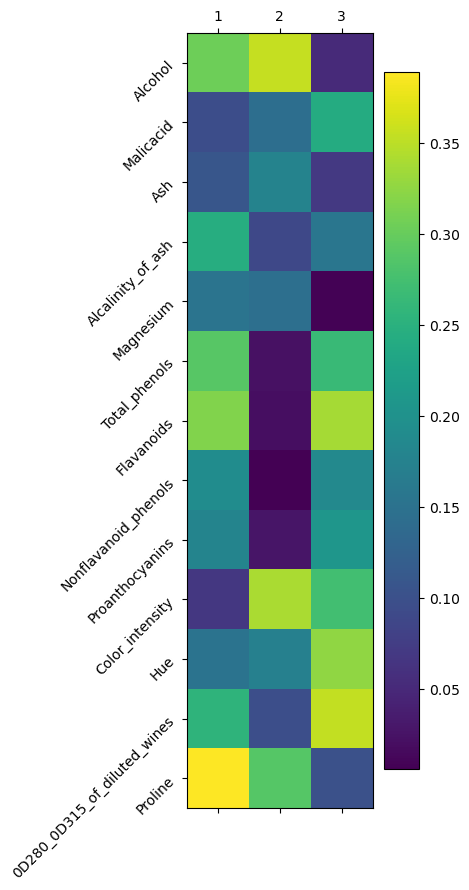

In [15]:
plt.figure(figsize = (10, 6))
plt.matshow(np.abs(pcc_matrix), aspect = 'auto')
plt.colorbar()
plt.yticks([i for i in range(wine_X_std.shape[1])], [i for i in wine_X.columns], rotation = 45)
plt.xticks([i for i in range(wine_y.shape[1])], [i for i in wine_y.columns])
fig = plt.gcf()
fig.set_size_inches(3, 10)

appears like all features at least have relevance to some class. if we had to remove, we could remove `ash` or `magnesium` or `nonflavanoid_phenols` if training time takes too long

<Figure size 1000x2000 with 0 Axes>

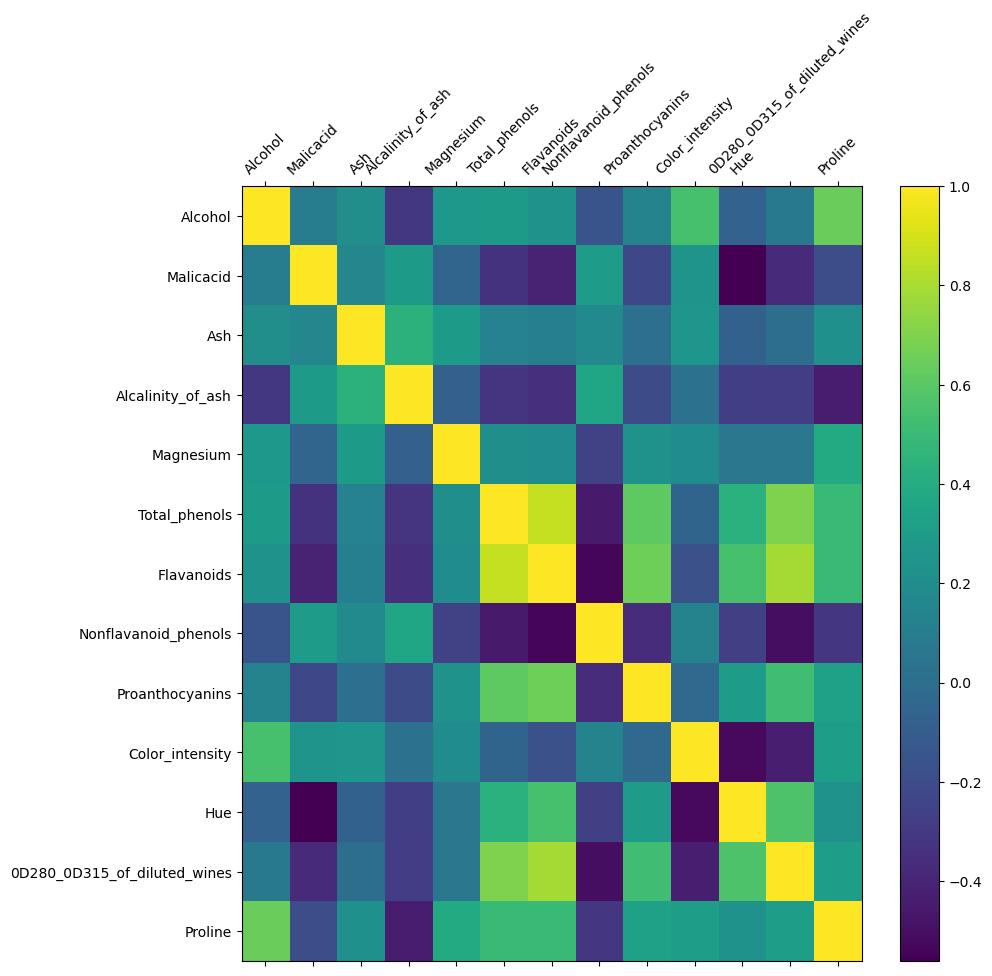

In [16]:
corr_wine_df = pd.DataFrame(wine_X_std).corr()
abs_corr_wine_df = np.abs(corr_wine_df)
plt.figure(figsize = (10, 20))
plt.matshow(corr_wine_df, aspect = 'auto')
plt.xticks([i for i in range(len(wine_X.columns))], [i for i in wine_X.columns], rotation = 45)
plt.yticks([i for i in range(len(wine_X.columns))], [i for i in wine_X.columns])
plt.colorbar()
fig = plt.gcf()
fig.set_size_inches(10, 10)

decent correlation between `flavanoids` and `total_phenols`, `flavanoids` and `0D280`, and `0d280` and `total_phenols`. so could remove one of them if training is slow

### Preprocessor

In [17]:
preproc = ColumnTransformer(
    transformers = [
        ('norm', StandardScaler(), wine_X.columns),
    ], remainder = 'passthrough'
)

In [18]:
# verify gradient calculations are correct
LRClassifier = LinearRegression(13, 3, loss_fn = ce_loss, get_grad = get_log_reg_grad)
LRClassifier.display_weights()
t1 = torch.Tensor(wine_X_std)
t2 = torch.Tensor(wine_y.to_numpy())


display(LRClassifier.verify_grad(t1, t2, 1e-4))


# LRClassifier.fit(t1, t2, epochs = 2)
# # LRClassifier.fit(t1, t2)
# probs = LRClassifier.predict_proba(t1)
# display(probs)
# display('losses')
# display(LRClassifier.losses)

'displaying weights..'

tensor([[ 1.5091e-02, -4.4727e-03, -1.8119e-02],
        [ 1.9264e-03, -9.0213e-03,  4.3647e-03],
        [ 4.1628e-03, -1.4099e-02, -7.9674e-03],
        [-4.3875e-03, -9.9072e-03, -1.3325e-06],
        [ 4.6862e-03,  9.2533e-04,  1.2496e-02],
        [ 1.1369e-02, -4.2429e-03,  5.3241e-03],
        [-8.7586e-04,  2.1190e-03, -1.7603e-02],
        [-1.8899e-03,  2.3554e-02,  7.4770e-03],
        [-5.4760e-03,  8.1977e-03, -1.7642e-02],
        [-2.4826e-02, -8.0329e-03,  1.5129e-02],
        [-1.2317e-02,  8.0481e-03,  3.7916e-03],
        [-1.6862e-02,  1.2746e-02, -1.1062e-02],
        [ 1.2495e-02, -9.0180e-03,  7.1228e-03]])

tensor([0., 0., 0.])

tensor([[False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False]])

In [19]:
# a = torch.tensor([[ 282096.5312,  -34918.1758, -271560.0938],
#                   [-188293.1250,   23322.3223,  181245.9688]])
# display(a)

# display(torch.softmax(a, dim = 1))

### TODO: 
1. fix gradient checker
2. fix homecooked loss
3. fix loss plotting 

- bad learning was the result of poor gradient calculation. `y - y_hat` being corrected to `y_hat - y` fixed the learning

- after fixing the gradient updates, the loss was still weird. this is because, the gradients were not tailored to the old loss function `cross entropy loss`, but instead were tailored to `mean square loss`. so while the `mean square loss` was being minimized, what we displayed was the `cross entropy loss` which our gradient was not tailored to. switching `cross entropy loss` to `mean square loss` fixed the issue.

NOTE: we made the mistake of thinking we were using a softmax within our model. in reality, we only use softmax for prediction. the actual training was done on the `self.forward` of a linear regression.

NOTE2: another mistake we made was with the cross entropy loss. `torch.sum()` with no dim provided sums the entire thing. we needed to pass it `dim = 1` in order to sum across columns. 

NOTE3: the `ce_loss` cross-entropy loss was not working with the `LinearRegression` model because `self.forward` could produce negative values in the multiple linear regression model. as a result, `torch.log` of a negative value yields **nans**, which then propagates to everything else being **nans**. we should only use `ce_loss` on a proper multiclass logistic regression model which performs `torch.softmax` during the `self.forward` call because then we do not get negatives. 

### Training Loop

np.float64(0.9433333333333334)

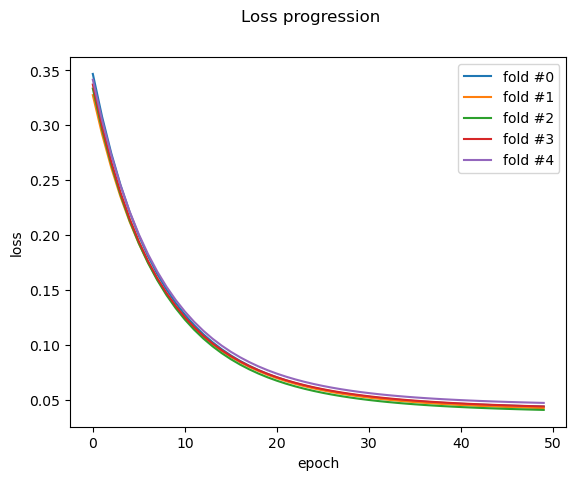

In [38]:

LRClassifier = LinearRegression(
    13, 3, loss_fn = mean_square_loss, get_grad = get_mse_grad
)

# constants
TEST_SIZE = 0.3
NUM_EPOCHS = 50
NUM_FOLDS = 5

fold_accs = []

# split data 
X_train, X_test, y_train, y_test = train_test_split(wine_X, wine_y, test_size = TEST_SIZE, random_state = 0)


kf = KFold(n_splits = NUM_FOLDS, random_state = 0, shuffle = True)

for fold_num, (train_ids, val_ids) in enumerate(kf.split(X_train, y_train)):

    # intialize regression
    LRClassifier = LinearRegression(
        13, 3, loss_fn = mean_square_loss, get_grad = get_mse_grad
    )
    # LRClassifier = LinearRegression(
    # 13, 3, loss_fn = ce_loss, get_grad = get_log_reg_grad
    # )

    infold_X = X_train.iloc[train_ids]
    infold_y = y_train.iloc[train_ids]
    
    # preprocess 
    infold_X_preproc = torch.Tensor(preproc.fit_transform(infold_X))
    infold_y = torch.Tensor(infold_y.to_numpy())

    # fit regression
    LRClassifier.fit(infold_X_preproc, infold_y, epochs = NUM_EPOCHS)
    
    # setup outfold data
    outfold_X = X_train.iloc[val_ids]
    outfold_y = y_train.iloc[val_ids]
    
    # preprocess
    outfold_X_preproc = torch.Tensor(preproc.fit_transform(outfold_X))
    outfold_y = torch.Tensor(outfold_y.to_numpy())
    
    # predict on outfold data
    preds = LRClassifier.predict(outfold_X_preproc)



    # DEBUG PRINTS
    # display('class probs')
    # display(LRClassifier.predict_proba(outfold_X_preproc)[:5])
    # display('predictions')
    # display(preds[:5])
    # display('labels')
    # display(outfold_y[:5])


    # calculate misclassification
    acc = np.sum([ 1 for i, j in zip(preds, outfold_y) if torch.equal(i, j)]) / preds.shape[0]
    fold_accs.append(acc)

    # display('losses')
    # display(LRClassifier.losses)
    plt.plot(
        [i for i in range(len(LRClassifier.losses))],
        LRClassifier.losses,
        label = f"fold #{fold_num}"
    )
plt.legend()
plt.suptitle("Loss progression")
plt.ylabel("loss")
plt.xlabel("epoch")


    
display(np.mean(fold_accs))

# plt.barh(
#     [i for i in range(len(fold_accs))],
#     fold_accs,
# )

### Minibatch Gradient Descent

np.float64(0.9343333333333333)

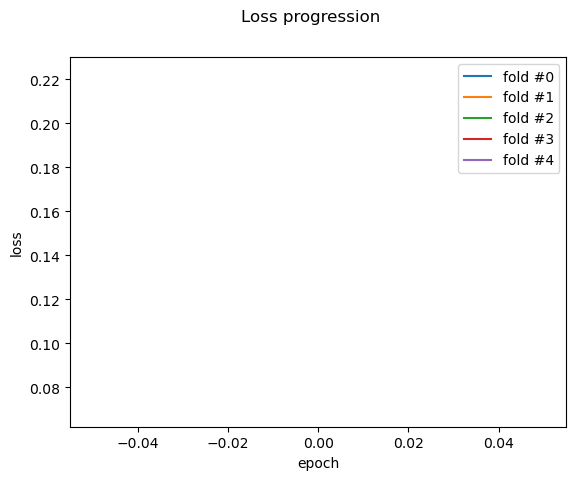

In [44]:

LRClassifier = LinearRegression(
    13, 3, loss_fn = mean_square_loss, get_grad = get_mse_grad
)

# constants
TEST_SIZE = 0.3
NUM_EPOCHS = 50
NUM_FOLDS = 5
MINIBATCH_SIZE = 2
gen = torch.Generator()
gen.manual_seed(0)
fold_accs = []

# split data 
X_train, X_test, y_train, y_test = train_test_split(
    wine_X, wine_y, test_size = TEST_SIZE, random_state = 0
)


kf = KFold(n_splits = NUM_FOLDS, random_state = 0, shuffle = True)

for fold_num, (train_ids, val_ids) in enumerate(kf.split(X_train, y_train)):

    # intialize regression
    LRClassifier = LinearRegression(
        13, 3, loss_fn = mean_square_loss, get_grad = get_mse_grad
    )

    infold_X = X_train.iloc[train_ids]
    infold_y = y_train.iloc[train_ids]


    # splitting minibatch
    minibatch_idxs = torch.randperm(infold_X.shape[0])
    cumulative_loss = 0

    # iterate through batch
    for j in range(0, infold_X.shape[0], MINIBATCH_SIZE):
        batch_X = infold_X.iloc[minibatch_idxs[j:j+MINIBATCH_SIZE]]
        batch_y = infold_y.iloc[minibatch_idxs[j:j+MINIBATCH_SIZE]]

        # preparing for fit
        batch_X_preproc = torch.Tensor(
            preproc.fit_transform(batch_X)
        )
        batch_y = torch.Tensor(
            batch_y.to_numpy()
        )

        custom_epochs = (int) ((NUM_EPOCHS)/(infold_X.shape[0] / MINIBATCH_SIZE))
        LRClassifier.fit(batch_X_preproc, batch_y, epochs = custom_epochs)

    
    # setup outfold data
    outfold_X = X_train.iloc[val_ids]
    outfold_y = y_train.iloc[val_ids]
    
    # preprocess
    outfold_X_preproc = torch.Tensor(preproc.fit_transform(outfold_X))
    outfold_y = torch.Tensor(outfold_y.to_numpy())
    
    # predict on outfold data
    preds = LRClassifier.predict(outfold_X_preproc)



    # DEBUG PRINTS
    # display('class probs')
    # display(LRClassifier.predict_proba(outfold_X_preproc)[:5])
    # display('predictions')
    # display(preds[:5])
    # display('labels')
    # display(outfold_y[:5])


    # calculate misclassification
    acc = np.sum([ 1 for i, j in zip(preds, outfold_y) if torch.equal(i, j)]) / preds.shape[0]
    fold_accs.append(acc)

    # display('losses')
    # display(LRClassifier.losses)
    plt.plot(
        [i for i in range(len(LRClassifier.losses))],
        LRClassifier.losses,
        label = f"fold #{fold_num}"
    )
plt.legend()
plt.suptitle("Loss progression")
plt.ylabel("loss")
plt.xlabel("epoch")


    
display(np.mean(fold_accs))

# plt.barh(
#     [i for i in range(len(fold_accs))],
#     fold_accs,
# )

Testing various minibatch sizes